In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

# energyflow imports
import energyflow as ef
from energyflow.utils import remap_pids

import inspect

Using TensorFlow backend.


In [3]:
print(tf.__version__)

1.15.0


# Load Data

## Utilities

In [4]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [5]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

## Process data

In [6]:
# Path to downloaded data from Zenodo
data_dir = './data/'

In [7]:
dataset = np.load(data_dir + '1D_alphaS_train.npz')

In [8]:
X = dataset['X']
Y = dataset['Y']

In [9]:
X = preprocess_data(X)
Y = to_categorical(Y, num_classes=2)

In [10]:
X_mult = []
#More preprocessing: zipping data points with no particle with parameters

index = 0
for jet in X:
    pTs = jet[:,0]
    alphaS = jet[0][4]
    multiplicity = np.sum(pTs!=0)
    X_mult.append([multiplicity, alphaS])


In [11]:
X_mult = np.array(X_mult)

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X_mult, Y, test_size=0.2)

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the first Gaussian Notebook.

## Build Model

In [13]:
inputs = Input((2,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam')

## Train DCTR model

In [14]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
               epochs=200, batch_size = 10000, 
               validation_data = (X_val, Y_val), 
               verbose = 1, 
               callbacks = [earlystopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1440000 samples, validate on 360000 samples
Epoch 1/200





1440000/1440000 [==============================] - 4s 3us/step - loss: 0.6931 - val_loss: 0.6925
Epoch 2/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6928 - val_loss: 0.6925
Epoch 3/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6927 - val_loss: 0.6926
Epoch 4/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6927 - val_loss: 0.6926
Epoch 5/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6926 - val_loss: 0.6925
Epoch 6/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6927 - val_loss: 0.6926
Epoch 7/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6925 - val_loss: 0.6923
Epoch 8/200
1440000/1440000 [==============================] - 2s 2us/step - loss:

# Alternative Fit

# Setup the dataset


In [15]:
default_dataset = np.load(data_dir + 'test1D_default.npz')
unknown_dataset = np.load(data_dir + 'test1D_alphaS.npz')

In [16]:
X_0 = default_dataset['multiplicity']
X_1 = unknown_dataset['multiplicity']

labels0 = np.zeros(len(X_0))
labels1 = np.ones(len(X_1))

xvals = np.concatenate([X_0,X_1])
yvals = np.concatenate([labels0,labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals, yvals, test_size=0.5)

# Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [17]:
def reweight(d): #from NN (DCTR)
    f = dctr_model(d)
    weights = (f[:,1])/(f[:,0])
    weights = K.expand_dims(weights, axis = 1)
    return weights

# Creating Model

In [18]:
myinputs = Input(shape=(1,), dtype = tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
model.summary()


def my_loss_wrapper(inputs,val=0):
    x  = inputs
    x = K.squeeze(x, axis = 1)
    x = K.gather(x, np.arange(500))

    theta = 0. #starting value
    #theta0 = tf.constant(val, dtype= tf.float32)#target value
    
    #creating tensor with same shape as inputs, with val in every entry
    theta0_stack = K.constant(val, dtype=tf.float32, shape = x.shape)
    #combining and reshaping into correct format:
    data = K.stack((x, theta0_stack), axis=-1) 
    
    w = reweight(data) #NN reweight
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        t_loss = y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2
        # Categorical Cross-Entropy Loss
        '''
        #Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


# Training Model

In [19]:
thetas = np.linspace(0.10, 0.18, 33)
lvals = []


for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam', loss=my_loss_wrapper(myinputs,theta),metrics=['accuracy'])
    model.fit(np.array(X_train), y_train, epochs=1, batch_size=500,validation_data=(np.array(X_test), y_test),verbose=1)
    lvals+=[model.history.history['val_loss']]
    print
    pass
print(lvals)

testing theta = : 0.1
Train on 900000 samples, validate on 900000 samples
Epoch 1/1
900000/900000 [==============================] - 9s 10us/step - loss: 0.2335 - acc: 0.5604 - val_loss: 0.2319 - val_acc: 0.5641
testing theta = : 0.10250000000000001
Train on 900000 samples, validate on 900000 samples
Epoch 1/1
900000/900000 [==============================] - 9s 10us/step - loss: 0.2322 - acc: 0.5626 - val_loss: 0.2353 - val_acc: 0.5608
testing theta = : 0.10500000000000001
Train on 900000 samples, validate on 900000 samples
Epoch 1/1
900000/900000 [==============================] - 9s 10us/step - loss: 0.2323 - acc: 0.5627 - val_loss: 0.2319 - val_acc: 0.5647
testing theta = : 0.1075
Train on 900000 samples, validate on 900000 samples
Epoch 1/1
900000/900000 [==============================] - 9s 10us/step - loss: 0.2326 - acc: 0.5628 - val_loss: 0.2322 - val_acc: 0.5647
testing theta = : 0.11
Train on 900000 samples, validate on 900000 samples
Epoch 1/1
900000/900000 [=================

In [20]:
lvals_orig= [[0.21545321300832762],
             [0.21320670744818118],
             [0.21427190159964893],
             [0.21600884579949908],
             [0.2180913633149531],
             [0.2203975125422908],
             [0.22277363829521668],
             [0.2252077442386912],
             [0.22762178098782898],
             [0.22985038127129276],
             [0.2319808946715461],
             [0.23389454455011421],
             [0.23567747064969605],
             [0.23733307556766603],
             [0.23912259595882562],
             [0.2411479534374343],
             [0.24305367945796913],
             [0.24457945177952448],
             [0.24594977470114826],
             [0.24723519961246185],
             [0.24829403785988688],
             [0.24910752758797672],
             [0.24965062933042645],
             [0.24994903881516722],
             [0.25001448064835535],
             [0.2498855436945127],
             [0.24953465532097552],
             [0.24896939413415062],
             [0.2482402424948911],
             [0.24736307265443935],
             [0.2463511453424063],
             [0.24517832743003964],
             [0.24393402135206593]]

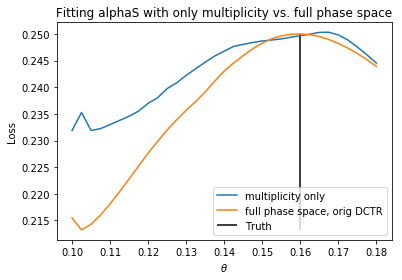

In [21]:
plt.plot(thetas,lvals, label = 'multiplicity only')
plt.plot(thetas, lvals_orig, label = 'full phase space, orig DCTR')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.title("Fitting alphaS with only multiplicity vs. full phase space")
plt.vlines(0.160, ymin = np.min(lvals_orig), ymax = np.max(lvals_orig), label = 'Truth')
plt.legend()
#plt.savefig("Fitting alphaS with only multiplicity vs full phase space.png")
plt.show()

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

In [37]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(". theta fit = ",model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = 0.12
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(model_fit.layers[-1].get_weights()[0]))

callbacks = [print_weights, append_fit_value]

In [38]:
myinputs_fit = Input(shape=(1,))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers)-1].add_weight(name="thetaX",shape=list(),initializer = keras.initializers.Constant(value = theta_fit_init),trainable=True)
model_fit.summary()

train_theta = False

batch_size = int(len(X_0)/50) #larger batch_size leads to better precision
epochs = 20 #but requires more epochs to train

def my_loss_wrapper_fit(inputs,mysign = 1):
    x  = inputs
    x = K.squeeze(x, axis = 1)
    x = K.gather(x, np.arange(batch_size))
    theta = 0. #starting value
    #Getting theta0:
    if train_theta == False:
        theta0 = model_fit.layers[-1].get_weights() #when not training theta, fetch as np array 
    else:
        theta0 = model_fit.trainable_weights[-1] #when trainingn theta, fetch as tf.Variable
        
    #creating tensor with same shape as inputs, with val in every entry 
    theta0_stack = K.ones_like(x,dtype=tf.float32)*theta0 
    
    #combining and reshaping into correct format:
    data = K.stack((x, theta0_stack), axis=-1) 
   
    w = reweight(data) #NN reweight
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        t_loss = mysign*(y_true*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2)
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        '''
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -mysign*((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        '''
        return K.mean(t_loss)
    return my_loss
    
for k in range(epochs):    
    print("Epoch: ",k )
    for i in range(len(model_fit.layers)-1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass
    
    train_theta = False
    model_fit.layers[-1].trainable = False
    #model.summary()    
    
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit,1),metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train), y_train, epochs=1, batch_size=batch_size,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=callbacks)

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers)-1):
        model_fit.layers[i].trainable = False
        pass    
    train_theta = True
    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer='adam', loss=my_loss_wrapper_fit(myinputs_fit,-1),metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train), y_train, epochs=1, batch_size=batch_size,validation_data=(np.array(X_test), y_test),verbose=1,callbacks=callbacks)    
    pass
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_27 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 129       
_________________________________________________________________
lambda_7 (Lambda)            (None, 1)                 1         
Total params: 16,898
Trainable params: 16,898
Non-trainable params: 0
_________________________________________________________________
Epoch:  0
Training g
Train on 900000 samples, validate on 900000 samples
Epoch 1/1
900000/900000 [==============================] - 9s 10u

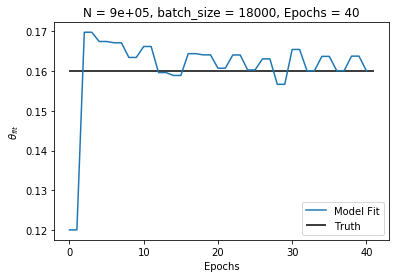

In [39]:
plt.plot(fit_vals, label='Model Fit')
plt.hlines(0.16, 0, len(fit_vals), label = 'Truth')
plt.xlabel("Epochs")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("N = {:.0e}, batch_size = {:.0f}, Epochs = {:.0f}".format(len(X_0), batch_size, epochs*2))
#plt.savefig(":N = {:.0e}, batch_size = {:.0f}, Epochs = {:.0f}".format(N, batch_size, epochs))
plt.show()